In [3]:
pip install  histomicstk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://girder.github.io/large_image_wheels
Note: you may need to restart the kernel to use updated packages.


In [5]:
import histomicstk as htk
print(htk.__version__)


1.3.11


In [6]:
pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

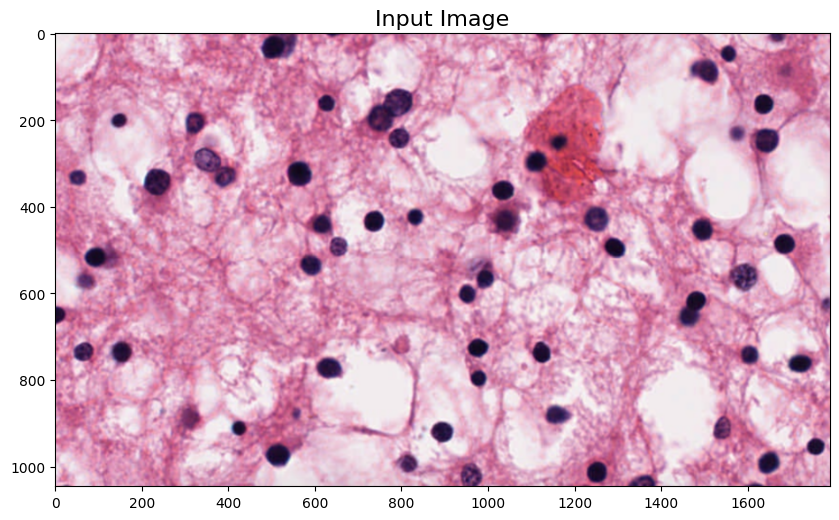

In [8]:
input_image_file = ('https://data.kitware.com/api/v1/file/'
                    '576ad39b8d777f1ecd6702f2/download')  # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

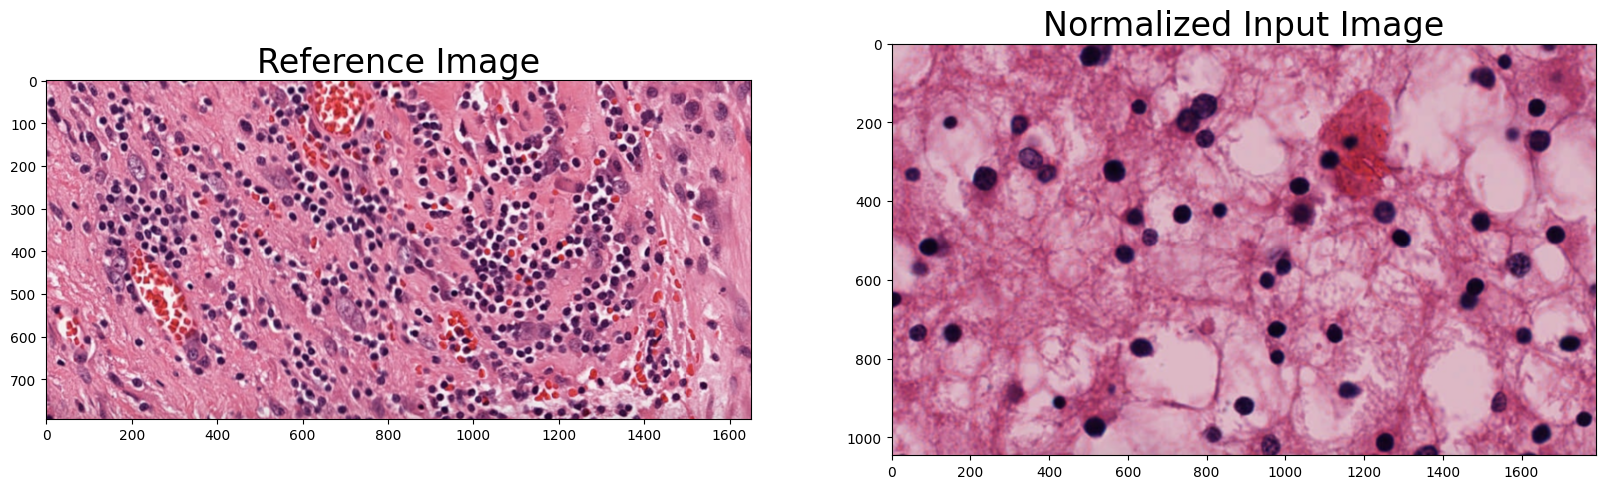

In [9]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

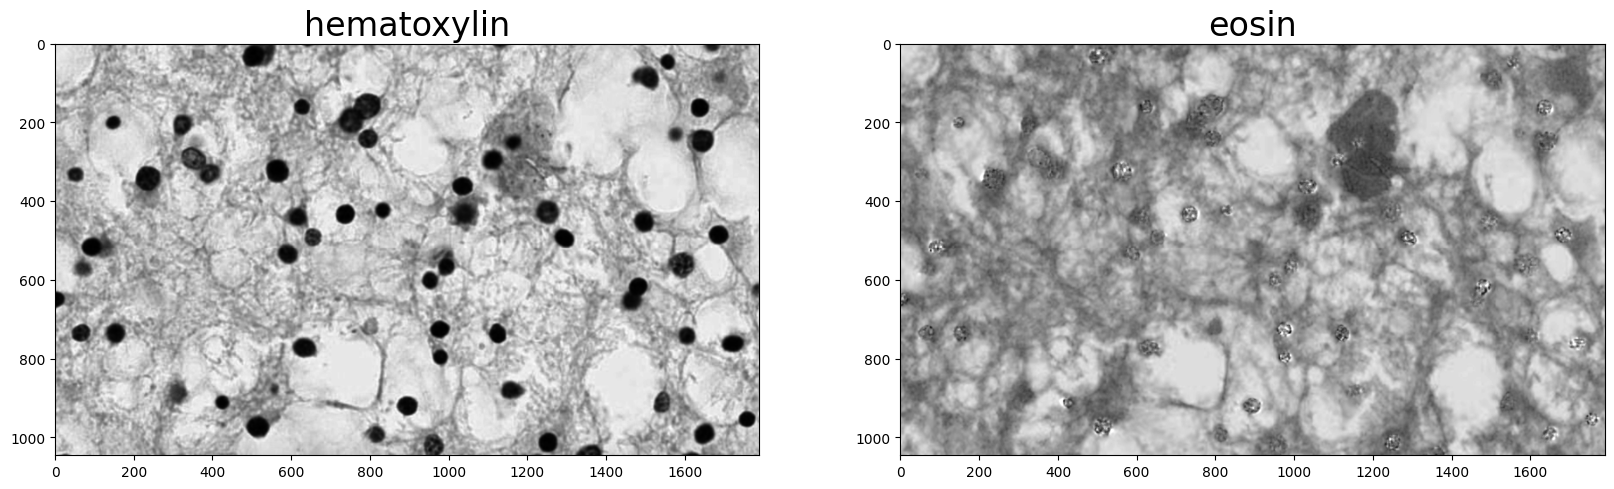

In [10]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0],
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

/tmp/ipykernel_935508/1758922410.py:7: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(


Number of nuclei =  65


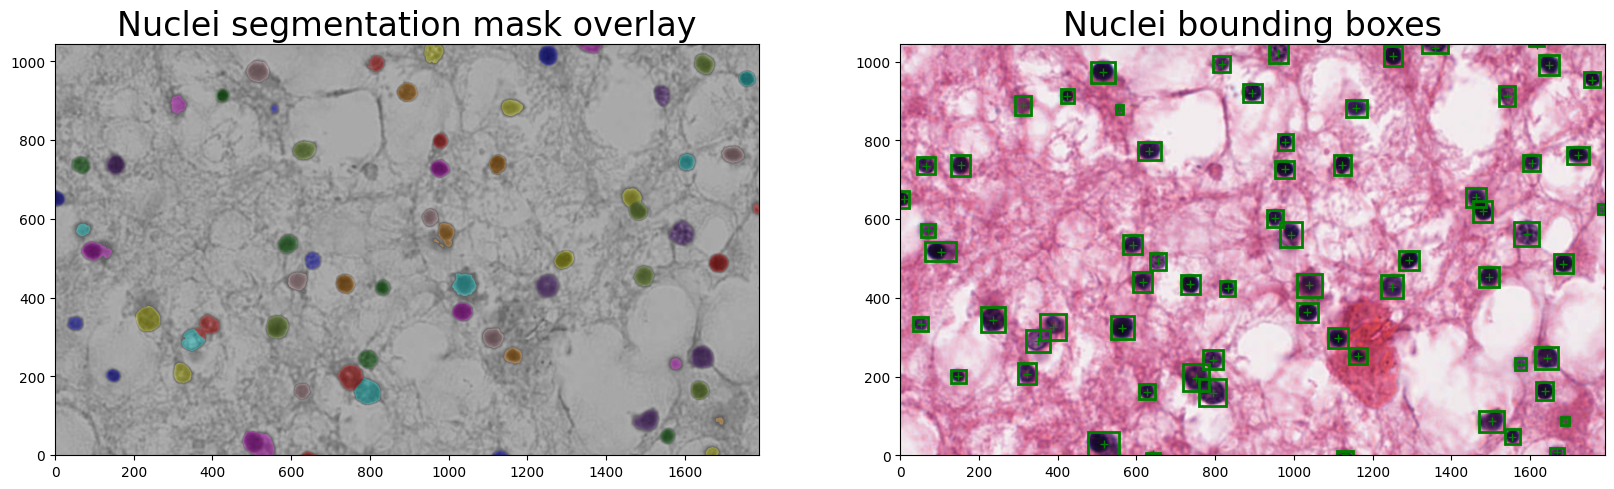

In [11]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2),
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(im_nuclei_seg_mask, min_nucleus_area).astype(int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        'type':        'rectangle',
        'center':      c,
        'width':       width,
        'height':      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [12]:
# Configuration and imports of other libraries
from __future__ import print_function

import large_image
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'

# Import and alias positive_pixel_count
import histomicstk.segmentation.positive_pixel_count as ppc


Input image


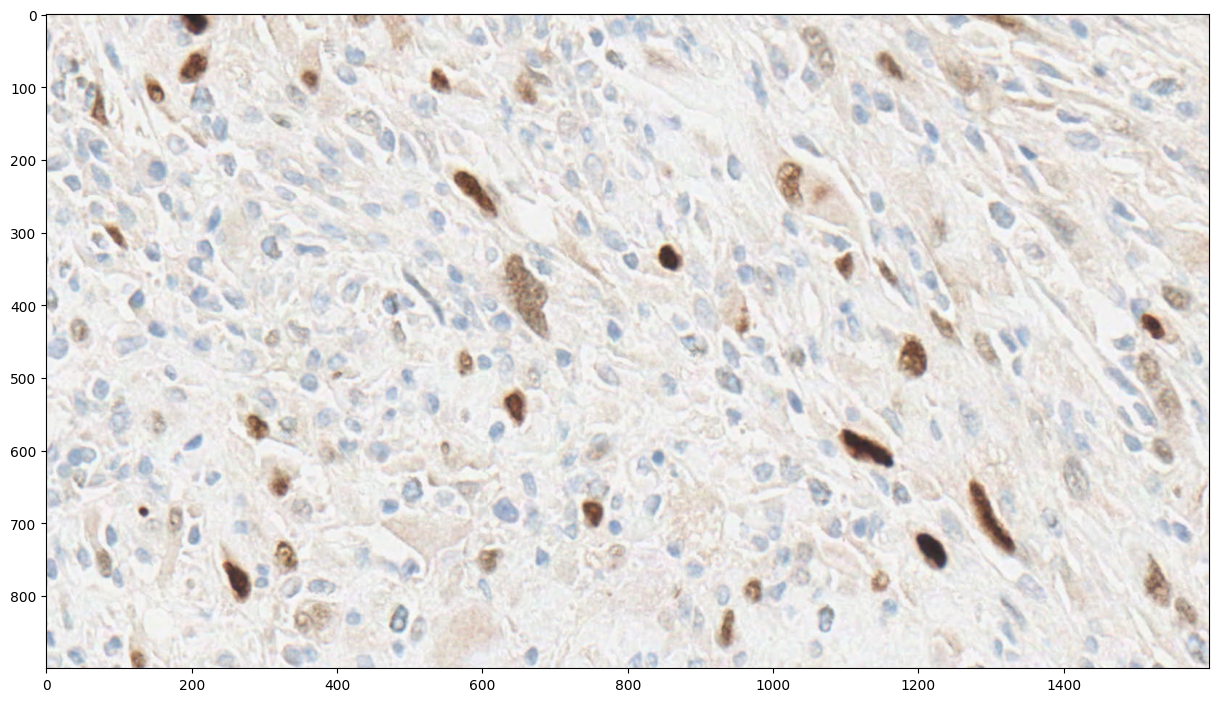

In [13]:
image_url = ('https://data.kitware.com/api/v1/file/'
             '598b71ee8d777f7d33e9c1d4/download')  # DAB.png

im_input = skimage.io.imread(image_url)

print('Input image')
plt.imshow(im_input)
plt.show()

In [14]:
def count_and_label(params):
    "Compute the label image with count_image, and then display it"
    label_image = ppc.count_image(im_input, params)[1]
    plt.imshow(label_image)
    plt.show()

In [15]:
pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [16]:
import ipywidgets as widgets
from ipywidgets import interactive

params= {
    'hue_value': widgets.FloatSlider(min=0.0,max=1.0,step=0.004,style = {'description_width': 'initial'}, value=0.05),
    'hue_width':widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.15),
    'saturation_minimum': widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.05),
    'intensity_upper_limit': widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.95),
    'intensity_weak_threshold': widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.65),
    'intensity_strong_threshold':widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.35),
    'intensity_lower_limit':widgets.FloatSlider(min=0.0,max=1.0,step=0.05,style = {'description_width': 'initial'}, value=0.05),
        }

def g(**params):
    count_and_label(ppc.Parameters(**params))

w = interactive(g,**params)
display(w)

template_params = ppc.Parameters(**w.kwargs)

interactive(children=(FloatSlider(value=0.05, description='hue_value', max=1.0, step=0.004, style=SliderStyle(…

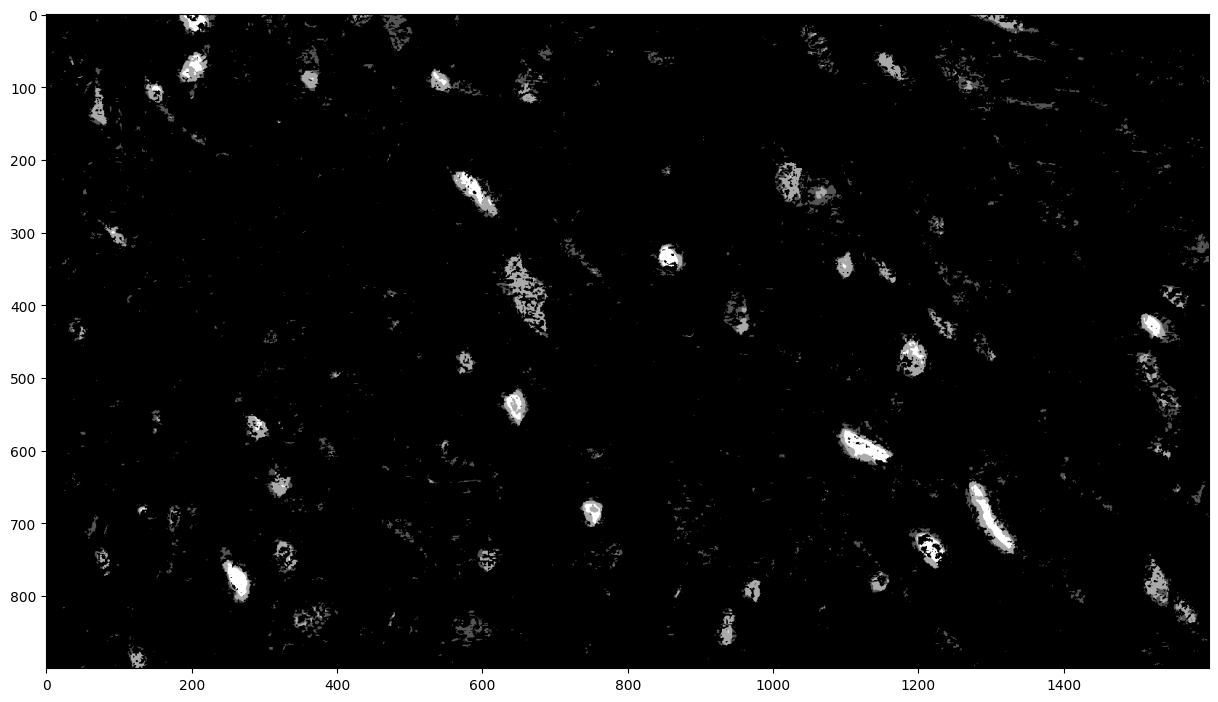

In [17]:
count_and_label(template_params._replace(hue_value=0.0))

In [18]:
stats, label_image = ppc.count_image(im_input, template_params)

def pp_namedtuple(t):
    "Pretty-print a namedtuple by printing each field on its own line and left-aligning all values"
    print(type(t).__name__)
    maxlen = max(map(len, t._fields))
    for f in t._fields:
        print(f, getattr(t, f), sep=':' + ' ' * (maxlen - len(f)) + '\t')

pp_namedtuple(stats)

Output
NumberWeakPositive:             	62260
NumberPositive:                 	25030
NumberStrongPositive:           	5649
NumberTotalPixels:              	1440000
IntensitySumWeakPositive:       	49625.11895424837
IntensitySumPositive:           	13184.654901960785
IntensitySumStrongPositive:     	1603.4444444444443
IntensityAverage:               	0.693069844743903
RatioStrongToTotal:             	0.060781803118174285
IntensityAverageWeakAndPositive:	0.7195529139215162
RatioStrongToPixels:            	0.0039229166666666666
RatioWeakToPixels:              	0.043236111111111114
RatioTotalToPixels:             	0.06454097222222223


In [19]:
# Comment this out (or just don't run it) once you have the file
!curl -OJ 'https://data.kitware.com/api/v1/file/598b5ee88d777f7d33e9c1d1/download'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header


In [20]:
# Set up a basic configuration.  Change as needed.
import dask.distributed

dask.distributed.Client()

<Client: 'tcp://127.0.0.1:45299' processes=8 threads=48, memory=30.90 GiB>

The region


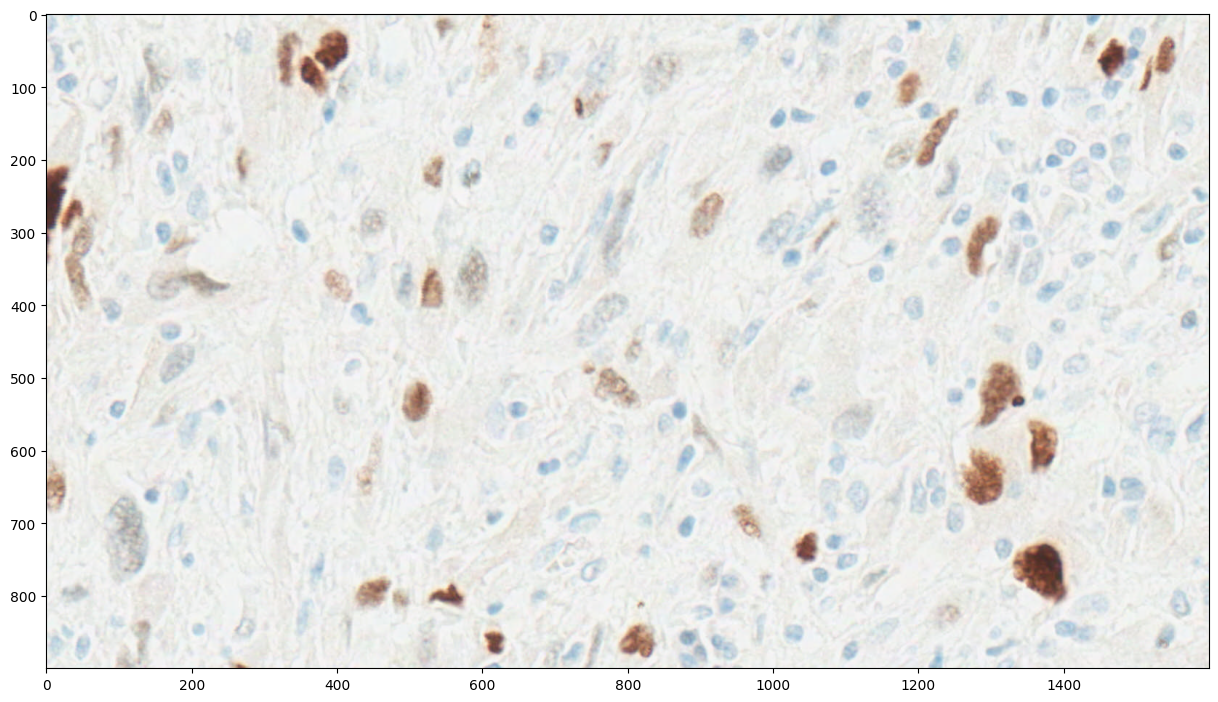

In [21]:
slide_path = 'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs'
region = dict(
    left=50000, top=35000,
    width=1600, height=900,
)

ts = large_image.getTileSource(slide_path)
im_region = ts.getRegion(region=region, format=large_image.tilesource.TILE_FORMAT_NUMPY)[0]

print('The region')
plt.imshow(im_region)
plt.show()

Output
NumberWeakPositive:             	33816
NumberPositive:                 	24626
NumberStrongPositive:           	4980
NumberTotalPixels:              	1440000
IntensitySumWeakPositive:       	26441.82091503268
IntensitySumPositive:           	12897.786928104573
IntensitySumStrongPositive:     	1414.7934640522876
IntensityAverage:               	0.642590919668089
RatioStrongToTotal:             	0.07852164863927344
IntensityAverageWeakAndPositive:	0.673139314929969
RatioStrongToPixels:            	0.0034583333333333332
RatioWeakToPixels:              	0.023483333333333332
RatioTotalToPixels:             	0.04404305555555556


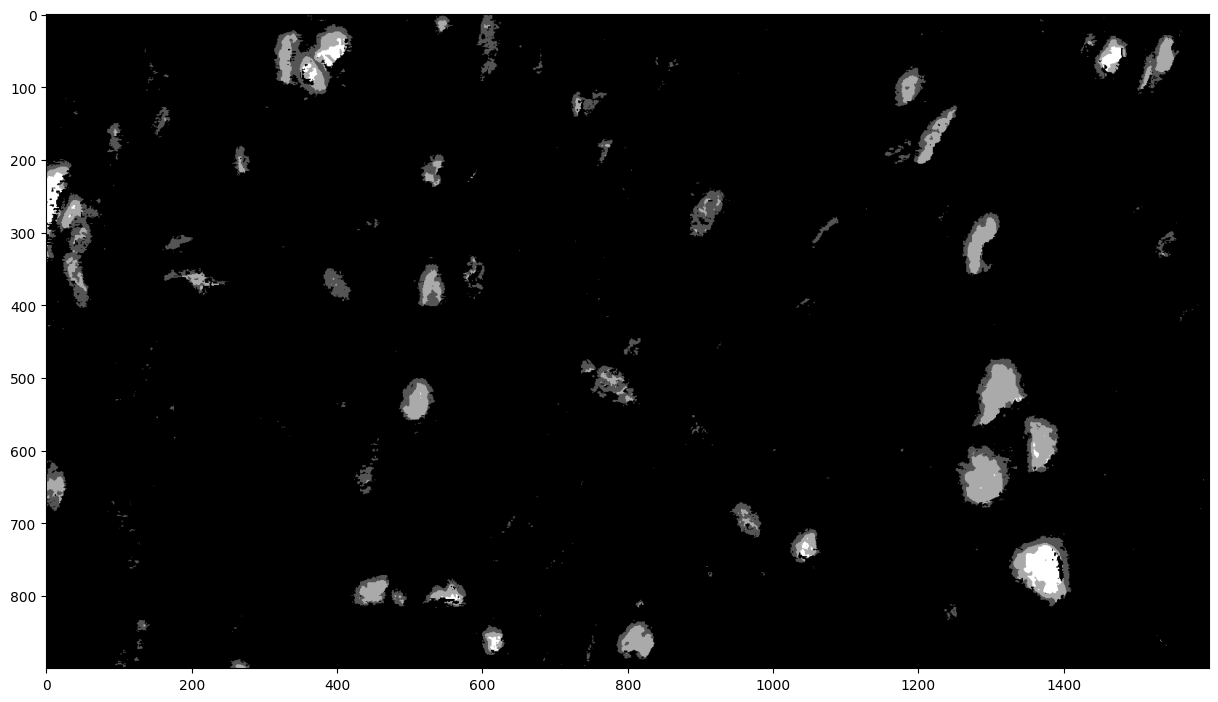

In [22]:
stats, label_image = ppc.count_slide(slide_path, template_params, region=region, make_label_image=True)
pp_namedtuple(stats)
plt.imshow(label_image)
plt.show()

In [23]:
# Note that we still return a tuple, though it now has length 1.
stats_dask, = ppc.count_slide(slide_path, template_params, region=region, tile_grouping=1)
pp_namedtuple(stats_dask)

Output
NumberWeakPositive:             	33816
NumberPositive:                 	24626
NumberStrongPositive:           	4980
NumberTotalPixels:              	1440000
IntensitySumWeakPositive:       	26441.820915032684
IntensitySumPositive:           	12897.786928104575
IntensitySumStrongPositive:     	1414.7934640522874
IntensityAverage:               	0.6425909196680891
RatioStrongToTotal:             	0.07852164863927344
IntensityAverageWeakAndPositive:	0.6731393149299691
RatioStrongToPixels:            	0.0034583333333333332
RatioWeakToPixels:              	0.023483333333333332
RatioTotalToPixels:             	0.04404305555555556


In [24]:
print('stats_dask - stats:')
pp_namedtuple(ppc.Output(**{f: getattr(stats_dask, f) - getattr(stats, f) for f in ppc.Output._fields}))

stats_dask - stats:
Output
NumberWeakPositive:             	0
NumberPositive:                 	0
NumberStrongPositive:           	0
NumberTotalPixels:              	0
IntensitySumWeakPositive:       	3.637978807091713e-12
IntensitySumPositive:           	1.8189894035458565e-12
IntensitySumStrongPositive:     	-2.2737367544323206e-13
IntensityAverage:               	1.1102230246251565e-16
RatioStrongToTotal:             	0.0
IntensityAverageWeakAndPositive:	1.1102230246251565e-16
RatioStrongToPixels:            	0.0
RatioWeakToPixels:              	0.0
RatioTotalToPixels:             	0.0


In [25]:
large_region = dict(
    left=60e3, top=30e3,
    width=30e3, height=30e3,
)

stats, = %time ppc.count_slide(slide_path, template_params, large_region)

pp_namedtuple(stats)

CPU times: user 1.46 s, sys: 617 ms, total: 2.08 s
Wall time: 14.3 s
Output
NumberWeakPositive:             	8180432
NumberPositive:                 	3804666
NumberStrongPositive:           	487363
NumberTotalPixels:              	900000000
IntensitySumWeakPositive:       	6443696.972549019
IntensitySumPositive:           	2033205.2810457516
IntensitySumStrongPositive:     	143778.6980392157
IntensityAverage:               	0.691177222493138
RatioStrongToTotal:             	0.03907512719422414
IntensityAverageWeakAndPositive:	0.7072868535238319
RatioStrongToPixels:            	0.0005415144444444445
RatioWeakToPixels:              	0.009089368888888888
RatioTotalToPixels:             	0.01385829
